# Numerische Daten

In [1]:
# Packete importieren
import pandas as pd
import numpy as np
import sklearn as sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

# Settings
#colors = ["#D0755E", "#B35097", "#68349A", "#E54E78", "#F66F6F"]

# Laden der Datensets aus Pickle File
with open('../output/titanic/datasets.pkl', 'rb') as handle:
    datasets = pickle.load(handle)

# Laden der Datensets aus Pickle File - ohne Ausreißer
with open('../output/titanic/datasets_or.pkl', 'rb') as handle:
    datasets_or = pickle.load(handle)

## Ausreißer erkennen

```{admonition} Was sind Ausreißer?
Ausreißer sind Daten die sich stark von den anderen Daten unterscheiden. Das Vorkommen ist selten und hebt sich in irgendeiner Art von den anderen Daten ab. 
```

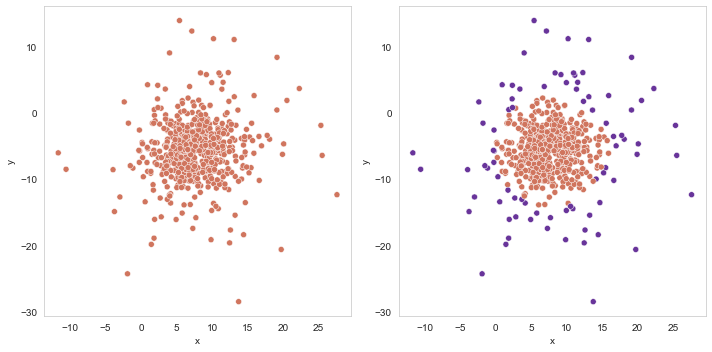

In [2]:
# Create sample data
from sklearn.ensemble import IsolationForest
X, y_true = make_blobs(n_samples=500, centers=1, cluster_std=3.20, random_state=5)
X_append, y_true_append = make_blobs(n_samples=100,centers=1, cluster_std=8,random_state=5)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] 

# Detect Outlier
sns.set_style("whitegrid", {'axes.grid' : False})
preds = IsolationForest(random_state=0).fit_predict(X)
list(preds).count(-1)
df = pd.DataFrame(preds, columns=['outlier'])
df['x'] = X[:,0]
df['y'] = X[:,1]
df['tmp'] = X[:,1].shape[0]*[1]

#customPalette = sns.set_palette(sns.color_palette(colors,n_colors=5))
d = {
    1: "#D0755E",
    -1: "#68349A"
}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.scatterplot(data=df, x="x", y="y", hue="tmp", palette=d, ax=axes[0], legend=False)
sns.scatterplot(data=df, x="x", y="y", hue="outlier", palette=d, ax=axes[1], legend=False)

fig.tight_layout()
plt.show()

In der linken Grafik sind eine Menge von Daten dargestellt. Jeder Punkt stellt ein Datensatz dar, der aus einem x- und einem y-Wert besteht. Auf der rechten Seite wurde eine Ausreißererkennung durchgeführt. Ausreißer sind lilafarben gekennzeichnet.

Ursachen für Ausreißer:
* **Eingabefehler**: Wenn z.B. Menschen Fehler bei der Eingabe von Hand gemacht haben.
* **Messfehler**: Beim Aufzeichnen von Daten sind Fehler entstanden.
* **Beschädigung**: Nachdem die Daten erfasst wurden, sind Fehler aufgetreteten. Zum Beispiel während der Verarbeitung.
* **Natürlich**: In diesem Fall handelt sich um keinen Fehler.

### Warum möchte man Ausreißer finden? 
Im Machine Learning Kontext können Ausreißer das **Training eines Modells negativ beeinflussen**. Dies kann sich in einem verzerrten Modell äußern. Infolge dessen liefert das Modell nicht die gewünschten Ergebnisse. **Nicht alle Ausreißer bringen eine negative Auswirkung mit sich**. Wenn die Ursache der Ausreißer natürlich ist, also kein Fehler, spiegeln die Ausreißer die Realität wieder und sollten nicht entfernt werden. Bei Anwendungsfällen wie z.B. der Katzenklappe, sind Momente, in denen eine Katze mit Beute vor der Klappe steht wesentlich seltener als Momente, in denen die Katze ohne Beute oder keine Katze vor der Klappe sichtbar ist. Die Zustände "Katze mit Beute" könnten als Ausreißer erkannt werden. In diesem Fall sind jedoch gerade diese Ausreißer von Bedeutung. Der Zustand "Katze mit Beute" ist kein Fehler und sollte nicht aus den Daten entfernt werden.

```{tip}
Stellen Sie sich die Frage:
**Sind die Ausreißer durch Fehler begründet?**   
Ja -> Ausreißer entfernen  
Nein -> Ausreißer im Datenset belassen  
```

### Am Beispiel des Titanic Datensets
#### Merkmal Alter 
Für das Merkmal "Alter" eines Menschen erwartet man einen Wert zwischen 0 und 122. Diesen Wertebereich kennt man aufgrund von Fachwissen: Der älteste Mensch wurde bisher 122 Jahre alt. Außerdem kann man den den Wertebereich weiter eingrenzen, wenn man annimmt, dass es sehr unwahrscheinlich ist, dass ein Mensch der älter als 100 Jahre ist, eine Reise über den Atlantik antritt. Alle Werte die **außerhalb des Wertebereichs von 0 und 100** liegen, bezeichnet man in diesem Fall als **Fehler**.

Die Verteilung und Ausreißer von numerischen Daten lassen sich sehr gut aus einem Boxplot ablesen. Ein Boxplot ist eine Methode zur grafischen Darstellung numerischen Daten durch ihre Quartile. Die Box erstreckt sich von den Q1- bis Q3-Quartilwerten der Daten, mit einer Linie am Median (Q2). Die Whisker erstrecken sich von den Rändern der Box, um den Bereich der Daten anzuzeigen. Standardmäßig erstrecken sie sich nicht weiter als 1,5 * IQR (IQR = Q3 - Q1) von den Rändern der Box und enden beim am weitesten entfernten Datenpunkt innerhalb dieses Intervalls. Ausreißer werden als separate Punkte gezeichnet.


```{figure} ../images/boxplot.png
---
height: 350px
align: left
name: fig-boxplot
---
```

Die Boxplots der numerischen Merkmale des Datensets Titanic, vermitteln einen ersten Eindruck der Verteilung der Daten.

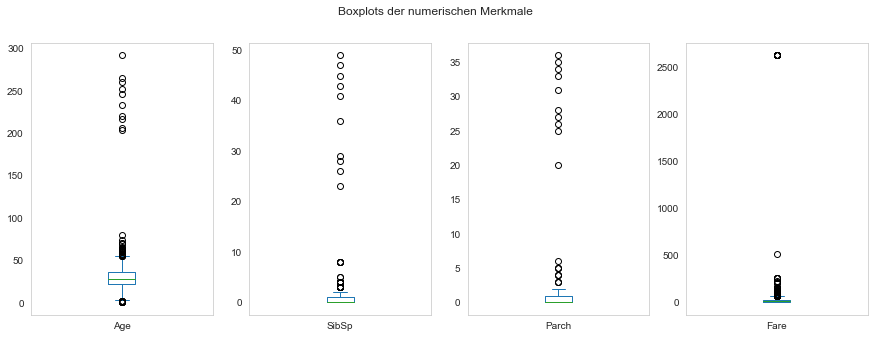

In [3]:
# Numerische Merkmale definieren
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']

# Eine Kopie des Trainingsdatenset erstellen und in einer Variable speichern 
X_train = datasets['X_train'].copy()

# Boxplot der numerischen Merkmale erstellen
X_train[numeric_features].plot(kind="box",subplots=True,figsize=(15,5),title="Boxplots der numerischen Merkmale");

Boxplots verwenden in der Standardeinstellung wie wir sie in der Abbildung sehen die Interquartile Range (IQR) - Methode für die Ausreißererkennung. Die IQR-Methode funktioniert wie folgt:
1. Das 25%-Quantil (Q1) berechnen
2. Das 75%-Quantil (Q3) berechnen
3. Q1 von Q3 subtrahieren (ergibt die Höhe der Box im Boxplot) = iqr
4. Die untere Grenze berechnen durch Q1 - (Faktor * iqr)
5. Die obere Grenze berechnen durch Q3 - (Faktor * iqr)

Wobei der Faktor variabel ist. Die Standardeinstellung beträgt 1,5.

Mit folgenden Codezeilen lassen sich die Ausreißer von den Daten des Merkmals "Alter" erkennen und anzeigen:

In [4]:
def get_outliers(s, factor, strategy=''):
  q1 = s.quantile(0.25)
  q3 = s.quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - (factor * iqr)
  upper_bound = q3 + (factor * iqr)
  outliers = s.loc[((s < lower_bound) | (s > upper_bound))].copy()
  
  if strategy=='remove':
    s[((s < lower_bound) | (s > upper_bound))] = np.nan
    s.dropna(inplace=True)
    
  return {
    'q1': q1, 
    'q3': q3,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound,
    'outliers': outliers,
    'data':s 
  }

def print_outliers(res):
  print('Q1-Quantil: ',res['q1'])
  print('Q3-Quantil: ',res['q3'])
  print('lower_bound: ',res['lower_bound'])
  print('upper_bound: ',res['upper_bound'])

  print('Anzahl der Ausreißer: ',res['outliers'].shape[0])
  print('Ausreißer')
  print(res['outliers'].sort_values())

feature = 'Age'  
factor = 1.5
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  22.75
Q3-Quantil:  36.0
lower_bound:  2.875
upper_bound:  55.875
Anzahl der Ausreißer:  44
Ausreißer
480      0.67
368      0.75
522      0.83
52       1.00
345      1.00
303      1.00
67       2.00
458      2.00
122      2.00
390      2.00
253      2.00
226     56.00
334     56.00
125     56.00
213     57.00
204     57.00
230     58.00
242     58.00
430     60.00
257     60.00
212     60.00
370     61.00
256     61.00
313     62.00
150     63.00
192     64.00
324     65.00
403     65.00
483     66.00
96      70.00
526     71.00
392     71.00
75      74.00
92      80.00
541    204.00
535    206.00
542    217.00
543    220.00
534    234.00
539    247.00
540    252.00
538    261.00
537    265.00
536    292.00
Name: Age, dtype: float64


Unter Verwendung des Faktor 1,5 (Standardwert), werden 44 Ausreißer erkannt. Alle Wert kleiner als 2.875 und größer als 55,875 werden als Ausreißer bezeichnet. Die Ausgabe der Ausreißerwerte zeigt, dass einige Werte durchaus plausibel sind. In diesem Fall, alle Werte bis einschließlich 80 und die Werte zwischen 0 und 2,875. 

> Es gibt wenige Menschen an Bord der Titanic, die jünger als 2,5 Jahre sind und wenige die zwischen 54,5 und 80 Jahre alt sind. Die Werte sind jedoch realistisch und sollten nicht entfernt werden.

Die letzten Werte von 204 bis 292 sind sicher Ausreißer. Fazit: **Lediglich die letzten 10 Werte sollten als Ausreißer erkannt werden**. In einem nächsten Schritt wird der **Faktorwert** entsprechend angepasst. Verwendet man einen Wert von **3,5 anstatt 1,5** liefert die Ausreißererkennung die erwarteten Werte.

In [5]:
feature = 'Age'  
factor = 3.5
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  22.75
Q3-Quantil:  36.0
lower_bound:  -23.625
upper_bound:  82.375
Anzahl der Ausreißer:  10
Ausreißer
541    204.0
535    206.0
542    217.0
543    220.0
534    234.0
539    247.0
540    252.0
538    261.0
537    265.0
536    292.0
Name: Age, dtype: float64


**Wie verhält es sich mit den Ausreißern der restlichen numerischen Merkmale?**  

#### Merkmal SibSp
Das Merkmal **SibSp** enthält die Anzahl der Geschwister oder Ehepartner, die mit an Bord der Titanic sind. Die Werte der Ausreißer liegen bei einem Faktor von 3.5 zwischen 5 und 49.

In [6]:
feature = 'SibSp'  
factor = 3.5
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  0.0
Q3-Quantil:  1.0
lower_bound:  -3.5
upper_bound:  4.5
Anzahl der Ausreißer:  17
Ausreißer
52      5
445     5
11      8
353     8
441     8
443     8
472     8
535    23
536    26
534    28
541    29
538    36
540    41
543    43
542    45
537    47
539    49
Name: SibSp, dtype: int64


Werte bis 8 erscheinen noch realistisch, nur Werte von 23 oder größer sollten als Ausreißer erkannt werden. Mit einem Faktor von 8 wird dieses Ziel erreicht.

In [7]:
feature = 'SibSp'  
factor = 8
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  0.0
Q3-Quantil:  1.0
lower_bound:  -8.0
upper_bound:  9.0
Anzahl der Ausreißer:  10
Ausreißer
535    23
536    26
534    28
541    29
538    36
540    41
543    43
542    45
537    47
539    49
Name: SibSp, dtype: int64


#### Merkmal Parch

Beim Merkmal **Parch** handelt es sich um die Anzahl der Eltern oder Kinder, die mit an Bord sind. Die Werte der Ausreißer betragen 3-66. 

In [8]:
feature = 'Parch'  
factor = 3.5
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  0.0
Q3-Quantil:  1.0
lower_bound:  -3.5
upper_bound:  4.5
Anzahl der Ausreißer:  14
Ausreißer
195     5
421     5
455     5
219     6
538    20
535    25
541    26
542    27
540    28
536    31
534    33
537    34
539    35
543    36
Name: Parch, dtype: int64


4 von den 14 erkannten Ausreißern besitzen die Werte 5 und 6. Diese Werte erscheinen realistisch. Die restlichen Werte liegen zwischen 20 und 36. Es handelt sich dabei höchst wahrscheinlich um Ausreißer. Mit einem Faktor von 8 werden die Ausreißer den entsprechenden Erwartungen erkannt.

In [9]:
feature = 'Parch'  
factor = 8
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  0.0
Q3-Quantil:  1.0
lower_bound:  -8.0
upper_bound:  9.0
Anzahl der Ausreißer:  10
Ausreißer
538    20
535    25
541    26
542    27
540    28
536    31
534    33
537    34
539    35
543    36
Name: Parch, dtype: int64


#### Merkmal Ticketpreis

Der Wertebereich der Ausreißer des **Ticketpreis** bei einem Faktor von 3.5 beträgt 113 bis 2630. 

In [10]:
feature = 'Fare'  
factor = 3.5
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  7.925
Q3-Quantil:  31.303124999999998
lower_bound:  -73.89843749999999
upper_bound:  113.12656249999998
Anzahl der Ausreißer:  35
Ausreißer
145     113.2750
319     120.0000
332     120.0000
333     120.0000
378     133.6500
359     133.6500
519     134.5000
268     134.5000
456     135.6333
447     135.6333
38      151.5500
468     151.5500
254     153.4625
66      164.8667
86      164.8667
249     211.3375
446     211.3375
530     221.7792
432     227.5250
532     262.3750
222     263.0000
192     263.0000
172     263.0000
108     263.0000
425     512.3292
534    2630.0000
535    2630.0000
536    2630.0000
537    2630.0000
538    2630.0000
539    2630.0000
540    2630.0000
541    2630.0000
542    2630.0000
543    2630.0000
Name: Fare, dtype: float64


Der Wert von 2630 erscheint sehr hoch und unrealistisch. Vermutlich handelt es sich hier um ein Eingabefehler. Der Wert 512 liegt weit über dem nächsten niedrigeren Wert von 263. Der einzelne sehr hohe Betrag von 512 könnte der Preis für eine Luxuskabine sein. Wird der Faktor auf 21 gesetzt, werden nur die unrealistischen Werte als Ausreißer erkannt.

In [11]:
feature = 'Fare'  
factor = 21
ser = pd.Series(X_train[feature]).copy()
res = get_outliers(ser, factor) 
print_outliers(res)

Q1-Quantil:  7.925
Q3-Quantil:  31.303124999999998
lower_bound:  -483.01562499999994
upper_bound:  522.24375
Anzahl der Ausreißer:  10
Ausreißer
534    2630.0
535    2630.0
536    2630.0
537    2630.0
538    2630.0
539    2630.0
540    2630.0
541    2630.0
542    2630.0
543    2630.0
Name: Fare, dtype: float64


### Methoden
Häufig verwendete Methoden zum Entfernen von Outlier:
* IQR-Methode
* DBScan Clustering
* Isolation Forest

Die Isolation Forest Methode und das DBScan Clustering können angewendet werden, wenn die Ausreißererkunng auf mehrdimensionalen Daten durchgeführt werden soll. Im Fall des Titanic Datenset werden die einzelnen Merkmale getrennt betrachtet, daher handelt es sich nicht um multivariate sondern um univariate Daten.

## Skalierung

Die Skalierung ist eine der wichtigsten Transformationen. Die meisten Machine Learning Algorithmen funktionieren nicht gut, wenn sich die Wertebereiche der Merkmale unterscheiden. Das ist bei den numerischen Merkmalen des Titanic Datenset[^footnote1] der Fall: 
* Das Alter der Passagiere liegt zwischen 0,67 und 80  
* Die Anzahl der Geschwister oder Ehepartner reicht von 0 bis 8  

Um die numerischen Merkmale auf die gleiche Skala zu bringen gibt es zwei übliche Verfahren:
1. Min-Max-Skalierung
2. Standardisierung

### Min-Max-Skalierung
Die Min-Max-Skalierung, auch Normalisierung genannt, ist eine Verschiebung der Werte in den Wertebereich von **0 und 1**. Hierzu wird zuerst der Minimalwert von allen Werten subtrahiert und anschließend alle Werte durch die Differenz von Maximal- und Minimalwert geteilt. 

Erzeugen von Beispieldaten, wobei der Minimalwert 10 und der Maximalwert 19 beträgt:

In [12]:
x = np.arange(10,20)
x

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

Subtrahieren des Minimalwertes und teilen durch die Differenz von Maximal- und Minimalwert:

In [13]:
x_scaled = (x - x.min())/(x.max()-x.min())
x_scaled

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

Ausgabe der neuen Minimal- und Maximalwerte

In [14]:
x_scaled.min()

0.0

In [15]:
x_scaled.max()

1.0

**Min-Max Skalierung am Beispiel Titanic** 

In der folgenden Abbildung sieht man die Werte des Merkmals Alter in einem Violin- und Swarmplot dargestellt. Ein **Violinplot** ist ähnlich wie ein Boxplot und stellt die **Verteilung der Daten** dar. Im Vergleich zum Boxplot wird die Verteilung nicht mit den Quartil-Werten dargestellt, sondern mit einem gespiegelten Kernel-Dichtediagramm. Der **Swarmplot** zeigt **alle Datenpunkte** einer Datenmenge. Daten mit dem gleichen Wert, werden **nicht überlappt dargestellt** sondern so gestapelt, dass jeder Datenpunkt sichtbar ist. Der Wertebereich liegt zwischen 0 und 80.

In [16]:
# Eine Kopie des Trainingsdatenset ohne Ausreißer erstellen und in einer Variable speichern 
X_train = datasets_or['X_train'].copy()

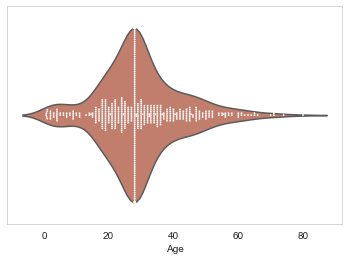

In [17]:
ax = sns.violinplot(data=X_train, x='Age', inner=None, color='#D0755E')
ax = sns.swarmplot(data=X_train, x='Age', size=1.8, orient="h", color="white")

```{hint} 
Die Plots werden mit Seaborn erstellt. [Seaborn](https://seaborn.pydata.org/) ist eine Python Bibliothek, die aufbauend auf Matplotlib, eine Vielzahl von Funktionen zur Visualisierung bereitstellt. Die verwendeten Funktionen sind [violinplot()](https://seaborn.pydata.org/generated/seaborn.violinplot.html) und [swarmplot()](https://seaborn.pydata.org/generated/seaborn.swarmplot.html).
```

Scikit-learn bietet einen MinMaxScaler an, mit dem sich die Min-Max-Skalierung einfach auf die Merkmale in einem Pandas Dataframe anwenden lassen. Als Rückgabe erhält man ein numpy-Array mit den skalierten Werten. Die Anwendung:
* MinMaxScaler importieren
* MinMaxScaler-Objekt erstellen
* der fit_transform Methode die Daten übergeben


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
df_scaled = pd.DataFrame(X_train_scaled, columns=X_train[numeric_features].columns)

Violoin- und Swarmplot zeigt, dass die Verteilung der sklalierten Werte gleich geblieben ist. Lediglich der Wertebereich hat sich auf 0 bis 1 geändert.

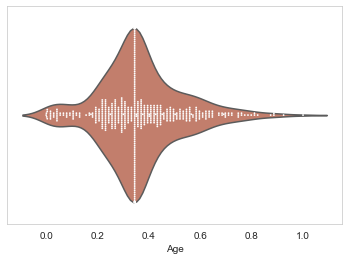

In [19]:
ax = sns.violinplot(data=df_scaled, x="Age", inner=None, color='#D0755E')
ax = sns.swarmplot(data=df_scaled, x="Age", size=1.8, orient="h", color="white")

### Standardisierung

Bei der Standardisierung wird zuerst der Mittelwert abgezogen. Das bewirkt, dass der Mittelwert der neuen Werte Null beträgt. In einem zweiten Schritt wird durch die Varianz geteilt. Daraus folgt eine Varianz von 1 bei den neuen Werten. 

Erzeugen von Beispieldaten, wobei der Minimalwert 10 beträgt und der Maximalwert 19:

In [20]:
x = np.arange(10,20)
x

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

Skalierung durch Standardisierung
* Mittelwert bestimmen
* Standardabweichung bestimmen
* Mittelwert subtrahieren und durch die Standardabweichung teilen

Mittelwert:

In [21]:
x.mean()

14.5

Standardabweichung:

In [22]:
x.std()

2.8722813232690143

Mittelwert subtrahiereun und durch die Standardabweichung teilen

In [23]:
x_scaled = (x - x.mean())/x.std()
x_scaled

array([-1.5666989 , -1.21854359, -0.87038828, -0.52223297, -0.17407766,
        0.17407766,  0.52223297,  0.87038828,  1.21854359,  1.5666989 ])

Neuer Mittelwert:

In [24]:
round(x_scaled.mean(),2)

-0.0

Neue Standardabweichung:

In [25]:
round(x_scaled.std(),2)

1.0

**Standardisierung am Beispiel Titanic**

Die StandardScaler-Methode von Scikit-Learn kann auf einen Pandas Dataframe angewendet werden. Als Rückgabe erhält man ein numpy-Array mit den skalierten Werten. Die Anwendung:
* StandardScaler importieren
* StandardScaler-Objekt erstellen
* fit_transform Methode die Daten übergeben

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
df_scaled = pd.DataFrame(X_train_scaled, columns=X_train[numeric_features].columns)

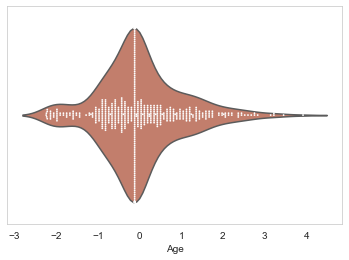

In [27]:
ax = sns.violinplot(data=df_scaled, x="Age", inner=None, color='#D0755E')
ax = sns.swarmplot(data=df_scaled, x="Age", size=1.8, orient="h", color="white")

Die Werte des Merkmals "Alter" wurden auf einen Wertebereich von -2,24 bis 3.92 skaliert. Der Mittelwert beträgt 0 und die Standardabweichung 1.

Das [Preprocessing Modul](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) der Scikit-learn Bibliothek bietet eine Reihe weiterere Transformationen an. Die Verwendung ist meist sehr ähnlich. Im Wesentlichen sind lediglich die drei Schritte "Importieren", "Objekt erzeugen" und "fit_transform-Methode aufrufen" notwendig um die Preprocessing-Methoden anzuwenden.

### Standardisierung oder Min-Max-Skalierung?

Die Standardabweichung hat im Vergleich zur Min-Max-Skalierung den Vorteil, dass Sie besser mit Ausreißer umgehen kann. Angenommen von 1000 Passagieren ist ein Passagier 110 Jahre alt, der Rest zwischen 20 und 30. Bei der Min-Max-Skalierung werden alle Werte zwischen 20 und 30 in den Bereich von 0-0.1 gequetscht. Bei der Standardisierung ändert sich durch den variablen Wertebereich nicht viel. Einige Algorithmen können nur mit Werten zwischen 0 und 1 umgehen, wie z.B. Neuronale Netze. In diesem Fall ist die Min-Max-Skalierung vorteilhaft.

```{Note}
Die meisten Machine Learning Verfahren funktionieren besser , wenn eine Skalierung der Daten vorgenommen wird. Welches Skalierungsverfahren eingesetzt werden sollte hängt von den Daten und den Anforderungen des Algorithmus ab.
```

## Diskretisierung

Die Diskretisierung, auch Binning genannt, **transformiert kontinuierliche in diskrete Werte**. Hierzu wird ein Set von zusammenhängenden Intervallen definiert, sogenannte **Bins** (Behälter). Jeder Behälter erhält einen Namen oder eine Regel wie die Elemente dieser Behälter benannt werden. Das kann zum Beispiel der Mittelwert der enthaltenen Elemente sein. Anschließend wird jeder kontinuierliche Wert **einem der Behälter zugewiesen und mit der Bezeichnung ersetzt**.

Erstellen von Beispieldaten:

In [28]:
x = [2, 6, 7, 12, 15, 18, 19, 34, 35, 40, 50]

### Diskretisierung in diskrete numerische Daten

Bestimmen von Bins:
* kleiner als 10
* 10-30
* größer als 30

Bezeichnung: Mittelwert der zugewiesenen Elemente

Umsetzung:

In [29]:
import statistics

bin1 = []
bin2 = []
bin3 = []
x_discretized = []

for value in x:
    if value < 10:
        bin1.append(value)
    elif (10 <= value <= 30):
        bin2.append(value)
    else:
        bin3.append(value)
        
print('Bins: ', bin1, bin2, bin3)
print('Mittelwert der Elemente der Bins: ', 
      statistics.mean(bin1), 
      ',',
      statistics.mean(bin2), 
      ',',
      statistics.mean(bin3)
)

for value in x:
    if value < 10:
        x_discretized.append(statistics.mean(bin1))
    elif (10 <= value <= 30):
        x_discretized.append(statistics.mean(bin2))
    else:
        x_discretized.append(statistics.mean(bin3))
        
print('Diskretisierte Werte: ', x_discretized)

Bins:  [2, 6, 7] [12, 15, 18, 19] [34, 35, 40, 50]
Mittelwert der Elemente der Bins:  5 , 16 , 39.75
Diskretisierte Werte:  [5, 5, 5, 16, 16, 16, 16, 39.75, 39.75, 39.75, 39.75]


### Diskretisierung in kategorische Daten

Bestimmen von Bins und Bezeichnung:
* kleiner als 10: 'niedrig'
* 10-30: 'mittel'
* größer als 30 : 'hoch'

Umsetzung:

In [30]:
x_discretized = []
for value in x:
    if value < 10:
        x_discretized.append('niedrig')
    elif (10 <= value <= 30):
        x_discretized.append('mittel')
    else:
        x_discretized.append('hoch')
        
x_discretized

['niedrig',
 'niedrig',
 'niedrig',
 'mittel',
 'mittel',
 'mittel',
 'mittel',
 'hoch',
 'hoch',
 'hoch',
 'hoch']

Es gibt verschiedene Arten um die Bins zu definieren. Über
1. die **gleiche Breite**: z.B. Werte von 0-10, 10-20, 30-40 usw.
2. die **gleiche Anzahl** von Elementen: z.B. Quantile
3. ein **Clustering**: z.B. Durchführen eines kmeans-Clustering
 
Die Scikit-Learn Bibliothek liefert eine Methode namens [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html), die eine Diskretisierung durchführt. Über den Parameter **strategy** bestimmt man die Art wie die Bins erstellt werden. Mögliche Werte:
* **uniform**: 1. Art, gleiche Breite
* **quantile**: 2. Art, gleiche Anzahl
* **kmeans**: 3. Art, Clustering


### Diskretisierung am Beispiel Titanic

Die Diskretisierung wird am Merkmal "Fare", dem Ticketpreis veranschaulicht. Mit dem Violin- und Swarmplot erhält man einen ersten Eindruck von den Daten.

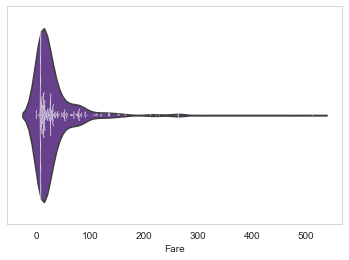

In [31]:
ax = sns.violinplot(data=X_train, x="Fare", inner=None, color='#68349A')
ax = sns.swarmplot(data=X_train, x="Fare", size=1, orient="h", color="white")

Der Violinplot zeigt, dass die Verteilung der Daten rechtsschief ist.

#### Diskretisierung mit gleicher Breite der Bins

In [32]:
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

X_train_fare_scaled = discretizer.fit_transform(X_train[['Fare']].values)
df_scaled = pd.DataFrame(X_train_fare_scaled, columns=X_train[['Fare']].columns)

Ausgabe der letzten fünf Zeilen der skalierten Werte:

In [33]:
df_scaled.tail()

,Fare
529,0.0
530,1.0
531,0.0
532,2.0
533,0.0


Bezeichnung der Bins:

In [34]:
df_scaled['Fare'].unique()

array([0., 1., 2., 3.])

Anzahl der Elemente pro Bin:

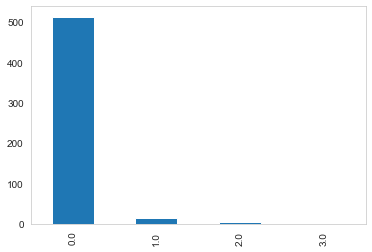

In [35]:
df_scaled['Fare'].value_counts().plot(kind='bar')

#### Diskretisierung mit gleicher Anzahl Elemente in Bins

In [36]:
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

X_train_fare_scaled = discretizer.fit_transform(X_train[['Fare']].values)
df_scaled = pd.DataFrame(X_train_fare_scaled, columns=X_train[['Fare']].columns)

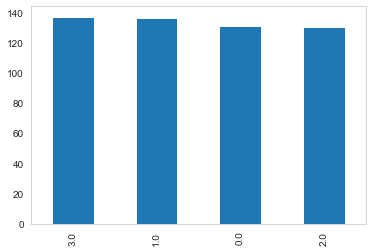

In [37]:
df_scaled['Fare'].value_counts().plot(kind='bar')

#### Diskretisierung mit Clustering

In [38]:
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

X_train_fare_scaled = discretizer.fit_transform(X_train[['Fare']].values)
df_scaled = pd.DataFrame(X_train_fare_scaled, columns=X_train[['Fare']].columns)

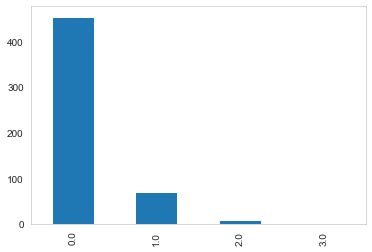

In [39]:
df_scaled['Fare'].value_counts().plot(kind='bar')

```{attention} 
Bei der Anwendung einer Diskretisierung ist zu beachten, dass **Informationen verloren** gehen. Das kann von Vorteil sein, wenn die verlorenen Informationen für den Anwendungsfall **nicht relevant** sind. Außerdem kann eine Diskretisierung eine vereinfachte Interpretation der Daten ermöglichen. Bewirkt eine Diskretisierung jedoch einen **Verlust von relevanten Informationen**, wirkt sich das negativ auf das Endergebnis aus.  
```

Mit Domänenwissen kann zunächst abgeschätzt werden, ob eine Diskretisierung erfolgsversprechend ist. Am Ende muss jedoch immer eine Erprobung stattfinden um sicher gehen zu können, dass eine Diskretisierung die Performance des Algorithmus steigert. Hierzu führt man **Experimente** mit unterschiedlichen **Transformationsmöglichkeiten** durch und **analysiert** das Ergebnis. Mehr dazu im Abschnitt "Optimierung". 

Im nächsten Abschnitt werden Transformationen für **kategorische Daten** behandelt.

[^footnote1]: Nach Entfernung der Ausreißer